In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%config InlineBackend.figure_format = 'retina'
from setup import *

In [5]:
def load_chunk_params(dirpath):
    dirpath = Path(dirpath)
    FishIs, ChunkJs = [], []
    Ts, Pbs, Ems = [], [], []
    for path in sorted(dirpath.glob("chunk-hmm-fish=*-chunk=*.hdf5")):
        name = path.stem
        fishi, chunkj = name.split("=")[1:]
        fishi = int(fishi.split("-")[0])
        chunkj = int(chunkj)
        FishIs.append(fishi)
        ChunkJs.append(chunkj)
        
        f = h5py.File(path, "r")
        T = f["transition_matrix"][:].T
        Pb = MC.steady_state(T)
        F = f["σforw"][:]
        Tu = f["turn"][:]
        f.close()
        Ts.append(T)
        Pbs.append(Pb)
        Ems.append(np.array([F[0], Tu[0], Tu[1]]))
    
    FishIs, ChunkJs = np.array(FishIs)-1, np.array(ChunkJs)-1
    Ts, Pbs, Ems = np.c_[Ts], np.c_[Pbs], np.c_[Ems]

    Nfish = len(np.unique(FishIs)) ; print(f"Nfish = {Nfish}")
    Nchunks = len(np.unique(ChunkJs)) ; print(f"Nchunks = {Nchunks}")
    
    Transitions = np.full((Nfish, Nchunks, Ts.shape[1], Ts.shape[2]), np.nan)
    SteadyState = np.full((Nfish, Nchunks, Pbs.shape[1]), np.nan)
    Emissions = np.full((Nfish, Nchunks, Ems.shape[1]), np.nan)
    for k in range(len(FishIs)):
        i, j = FishIs[k], ChunkJs[k]
        Transitions[i,j] = Ts[k]
        SteadyState[i,j] = Pbs[k]
        Emissions[i,j] = Ems[k]

    return Transitions, SteadyState, Emissions

def load_global_params(dirpath):
    dirpath = Path(dirpath)
    FishIs = []
    Ts, Pbs, Ems = [], [], []
    for path in sorted(dirpath.glob("global-hmm-fish=*.hdf5")):
        name = path.stem
        fishi = int(name.split("=")[1])
        FishIs.append(fishi)
        
        f = h5py.File(path, "r")
        T = f["transition_matrix"][:].T
        Pb = MC.steady_state(T)
        F = f["σforw"][:]
        Tu = f["turn"][:]
        f.close()
        Ts.append(T)
        Pbs.append(Pb)
        Ems.append(np.array([F[0], Tu[0], Tu[1]]))
    
    FishIs = np.array(FishIs)-1
    Ts, Pbs, Ems = np.c_[Ts], np.c_[Pbs], np.c_[Ems]

    Nfish = len(np.unique(FishIs)) ; print(f"Nfish = {Nfish}")
    
    Transitions = np.full((Nfish, Ts.shape[1], Ts.shape[2]), np.nan)
    SteadyState = np.full((Nfish, Pbs.shape[1]), np.nan)
    Emissions = np.full((Nfish, Ems.shape[1]), np.nan)
    for k in range(len(FishIs)):
        i = FishIs[k]
        Transitions[i] = Ts[k]
        SteadyState[i] = Pbs[k]
        Emissions[i] = Ems[k]

    return Transitions, SteadyState, Emissions

In [6]:
def id_ax(ax, X,Y,dY, limitxy=False, mislabeled=[0,4,7,17]):
    ax.errorbar(X, Y, fmt="o", yerr=dY, markersize=1, capsize=1, linewidth=0.5, capthick=0.5)
    ax.errorbar(X[mislabeled], Y[mislabeled], fmt="o", yerr=dY[mislabeled], markersize=1, capsize=1, linewidth=0.5, capthick=0.5)
    if limitxy:
        mmin, mmax = 0,1
    else:
        xmin, xmax = X.min(), X.max()
        ymin, ymax = (Y-dY).min(), (Y+dY).max()
        mmin, mmax = min(xmin, ymin)-0.02, max(xmax, ymax)+0.02
    ax.plot([mmin,mmax], [mmin,mmax], color="grey", linewidth=1, zorder=0)
    ax.set_xlim(mmin,mmax)
    ax.set_ylim(mmin,mmax)

# Figure

## Panel : Model params

In [7]:
Tchunks, Pchunks, Echunks = load_chunk_params("../Models/longtrajectories_20240202/")
Tglobs, Pglobs, Eglobs = load_global_params("../Models/longtrajectories_20240202/")

Tchunks_m = np.nanmean(Tchunks, axis=1)
Tchunks_s = np.nanstd(Tchunks, ddof=1, axis=1) / np.sqrt(Tchunks.shape[1])
Pchunks_m = np.nanmean(Pchunks, axis=1)
Pchunks_s = np.nanstd(Pchunks, ddof=1, axis=1) / np.sqrt(Pchunks.shape[1])
Echunks_m = np.nanmean(Echunks, axis=1)
Echunks_s = np.nanstd(Echunks, ddof=1, axis=1) / np.sqrt(Pchunks.shape[1])

Nfish = 18
Nchunks = 10
Nfish = 18


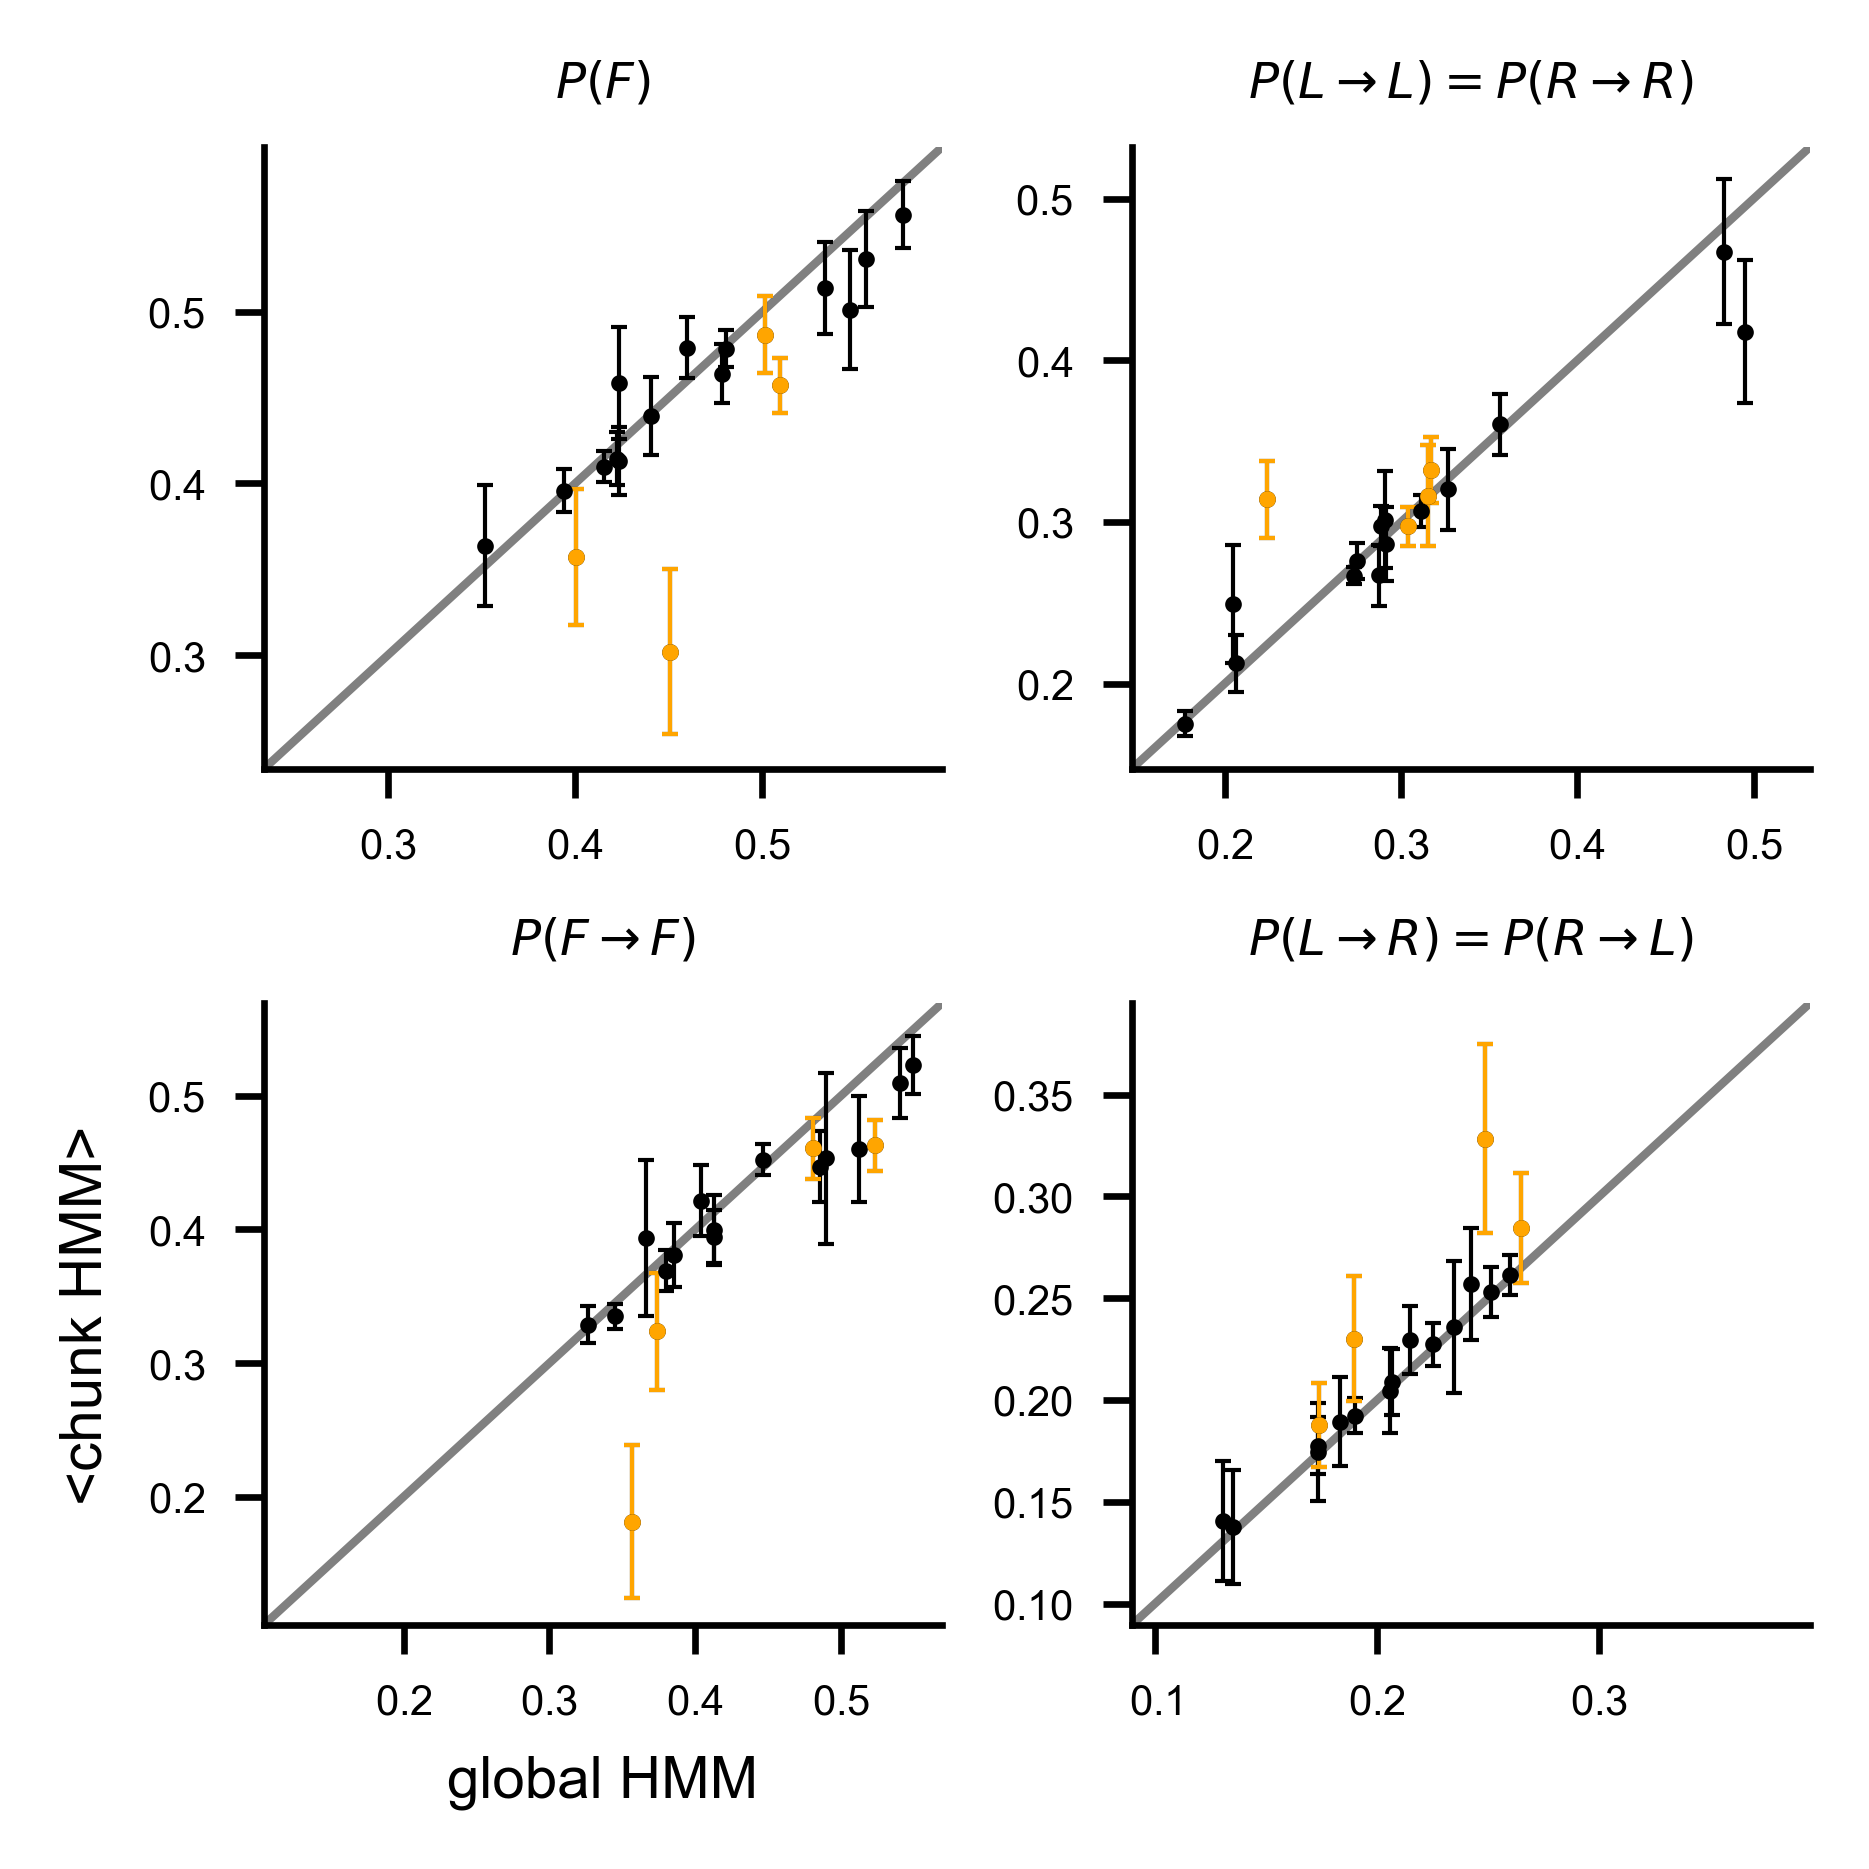

In [9]:
fig, axs = plt.subplots(figsize=(3,3), ncols=2, nrows=2, constrained_layout=True)

ax = axs[0,0]
ax.set_title(r"$P(F)$",fontdict={'fontsize':6})
id_ax(ax, Pglobs[:,0], Pchunks_m[:,0], Pchunks_s[:,0])

ax = axs[1,0]
ax.set_title(r"$P(F \rightarrow F)$",fontdict={'fontsize':6})
id_ax(ax, Tglobs[:,0,0], Tchunks_m[:,0,0], Tchunks_s[:,0,0])

ax = axs[0,1]
ax.set_title(r"$P(L \rightarrow L) = P(R \rightarrow R)$",fontdict={'fontsize':6})
id_ax(ax, Tglobs[:,1,1], Tchunks_m[:,1,1], Tchunks_s[:,1,1])

ax = axs[1,1]
ax.set_title(r"$P(L \rightarrow R) = P(R \rightarrow L)$",fontdict={'fontsize':6})
id_ax(ax, Tglobs[:,1,2], Tchunks_m[:,1,2], Tchunks_s[:,1,2])

ax = axs[1,0]
ax.set_xlabel("global HMM")
ax.set_ylabel("<chunk HMM>")

fig.savefig("panels/Fig5/id_params.svg")

## Panel : Prediction curve

In [12]:
fs = np.loadtxt("../Models/longtrajectories_20240202/subsampling_fracs.txt")
preds = np.loadtxt("../Models/longtrajectories_20240202/subsampling_N_correct_predictions.txt")

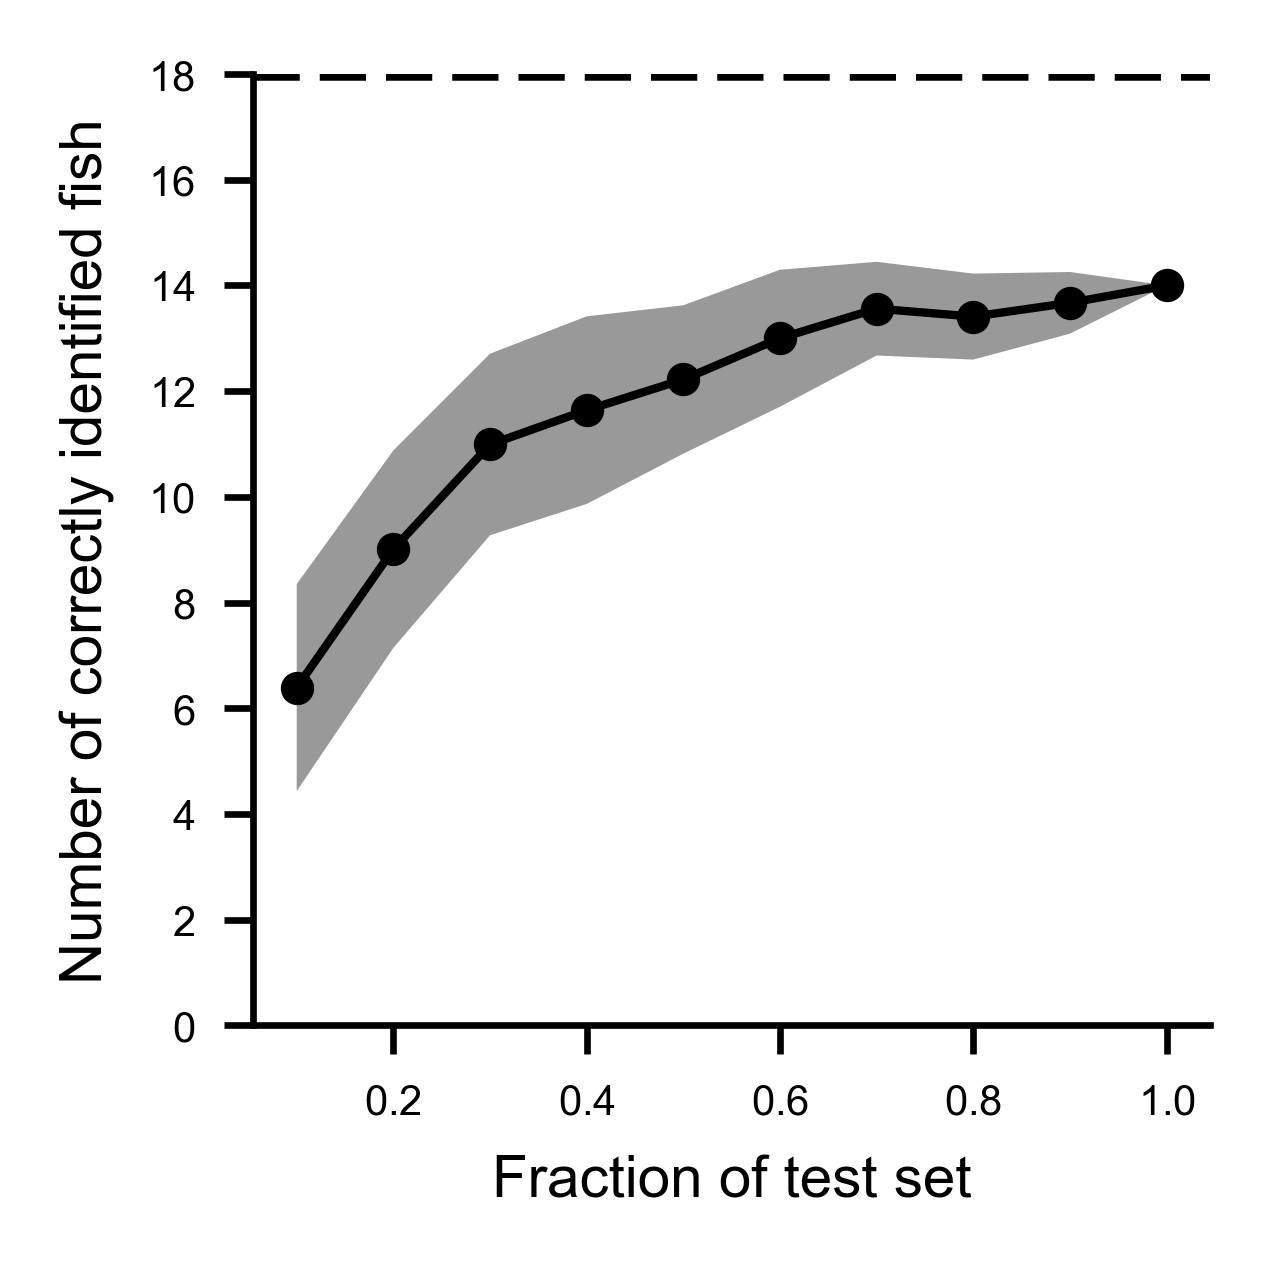

In [15]:
mp, sp = preds.mean(axis=1), preds.std(axis=1)
fig, ax = plt.subplots()
ax.plot(fs, mp, "-o", color="k", markersize=3, linewidth=1)
ax.fill_between(fs, mp-sp, mp+sp, color="k", alpha=0.4, edgecolor=None)
ax.axhline(18, linestyle="--", color="k")
ax.set_ylim(0,18)
ax.set_xlabel("Fraction of test set")
ax.set_ylabel("Number of correctly identified fish")

fig.savefig("panels/Fig5/identification_curve.svg")

## Panel : confusion matrix

In [16]:
Ls = np.loadtxt("../Models/longtrajectories_20240202/L_confusion_matrix.txt").T
rLs = Ls / np.diagonal(Ls)[:,np.newaxis]

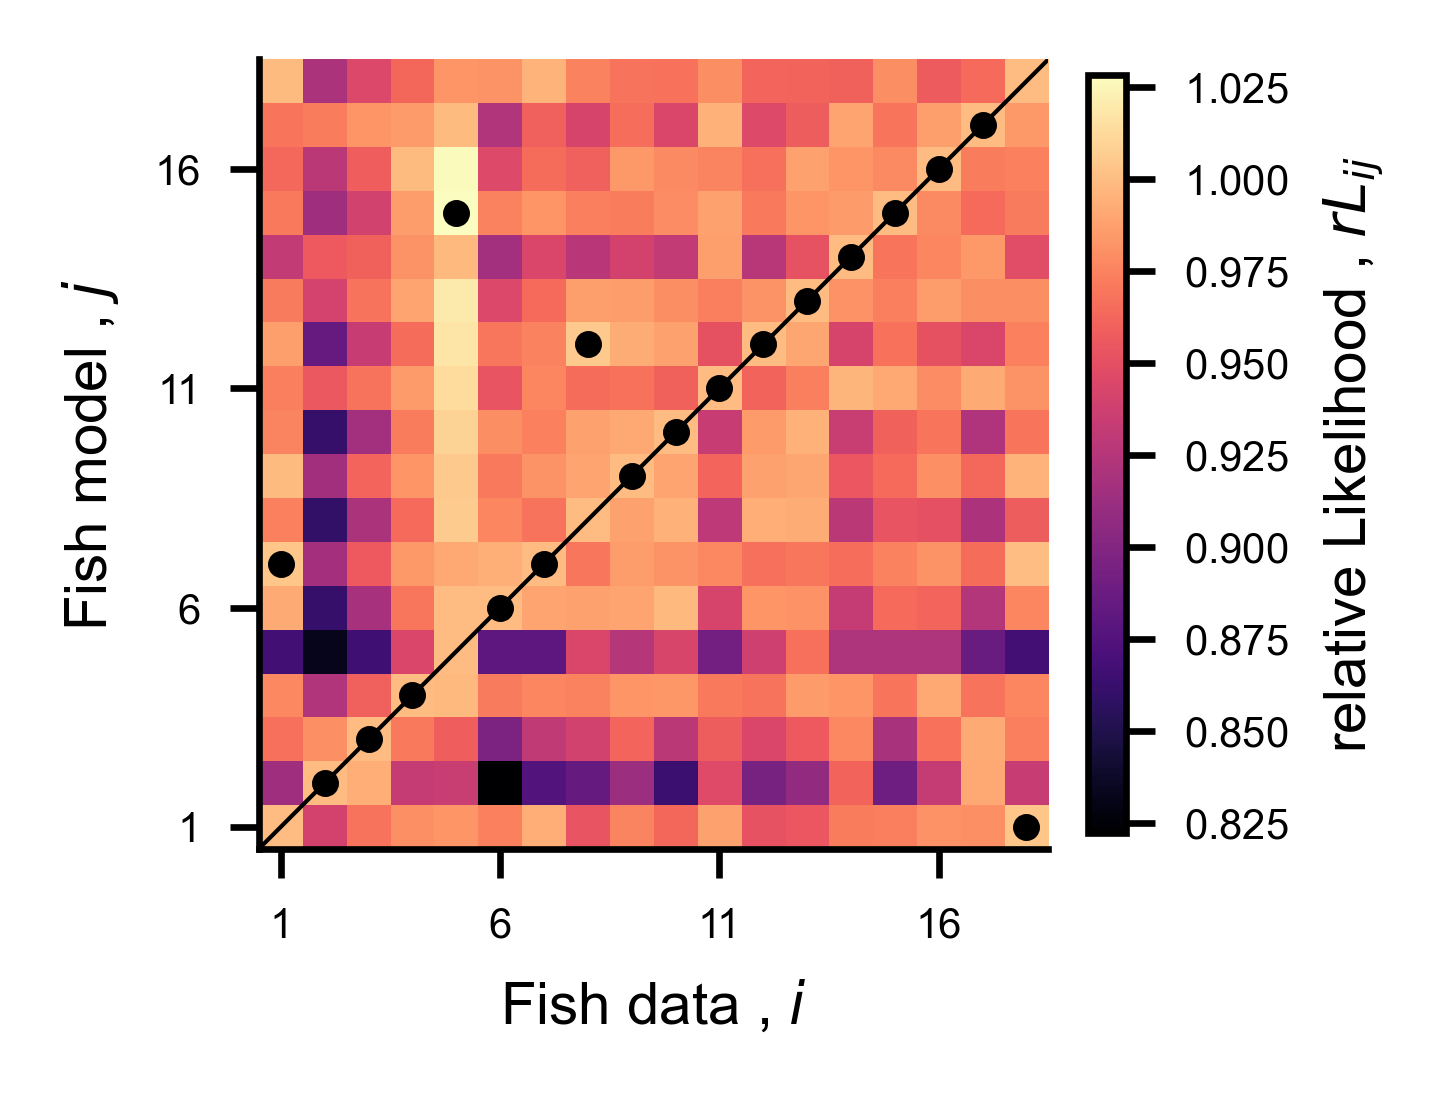

In [18]:
fig, ax = plt.subplots(figsize=(2.3,2))

x = np.arange(Ls.shape[0])
y = np.argmax(Ls, axis=1)

h = ax.imshow(
    rLs.T, 
    cmap="magma",
    aspect="equal", rasterized=True,
)
fig.colorbar(h, ax=ax, label=r"relative Likelihood , $rL_{ij}$", shrink=0.7)

ax.scatter(x,y, s=5, color="k")
ax.plot([-.5,17.5], [-0.5,17.5], linewidth=0.5)

xticks = np.arange(0,18, 5)
ax.set_xticks(xticks, labels=xticks+1)
ax.set_yticks(xticks, labels=xticks+1)
ax.set_xlabel(r"Fish data , $i$")
ax.set_ylabel(r"Fish model , $j$")

fig.savefig("panels/Fig5/confusion_matrix.svg")

# Supplementaries

## All Model params

In [10]:
Tchunks, Pchunks, Echunks = load_chunk_params("../Models/longtrajectories_20240202/")
Tglobs, Pglobs, Eglobs = load_global_params("../Models/longtrajectories_20240202/")

Tchunks_m = np.nanmean(Tchunks, axis=1)
Tchunks_s = np.nanstd(Tchunks, ddof=1, axis=1) / np.sqrt(Tchunks.shape[1])
Pchunks_m = np.nanmean(Pchunks, axis=1)
Pchunks_s = np.nanstd(Pchunks, ddof=1, axis=1) / np.sqrt(Pchunks.shape[1])
Echunks_m = np.nanmean(Echunks, axis=1)
Echunks_s = np.nanstd(Echunks, ddof=1, axis=1) / np.sqrt(Pchunks.shape[1])

Nfish = 18
Nchunks = 10
Nfish = 18


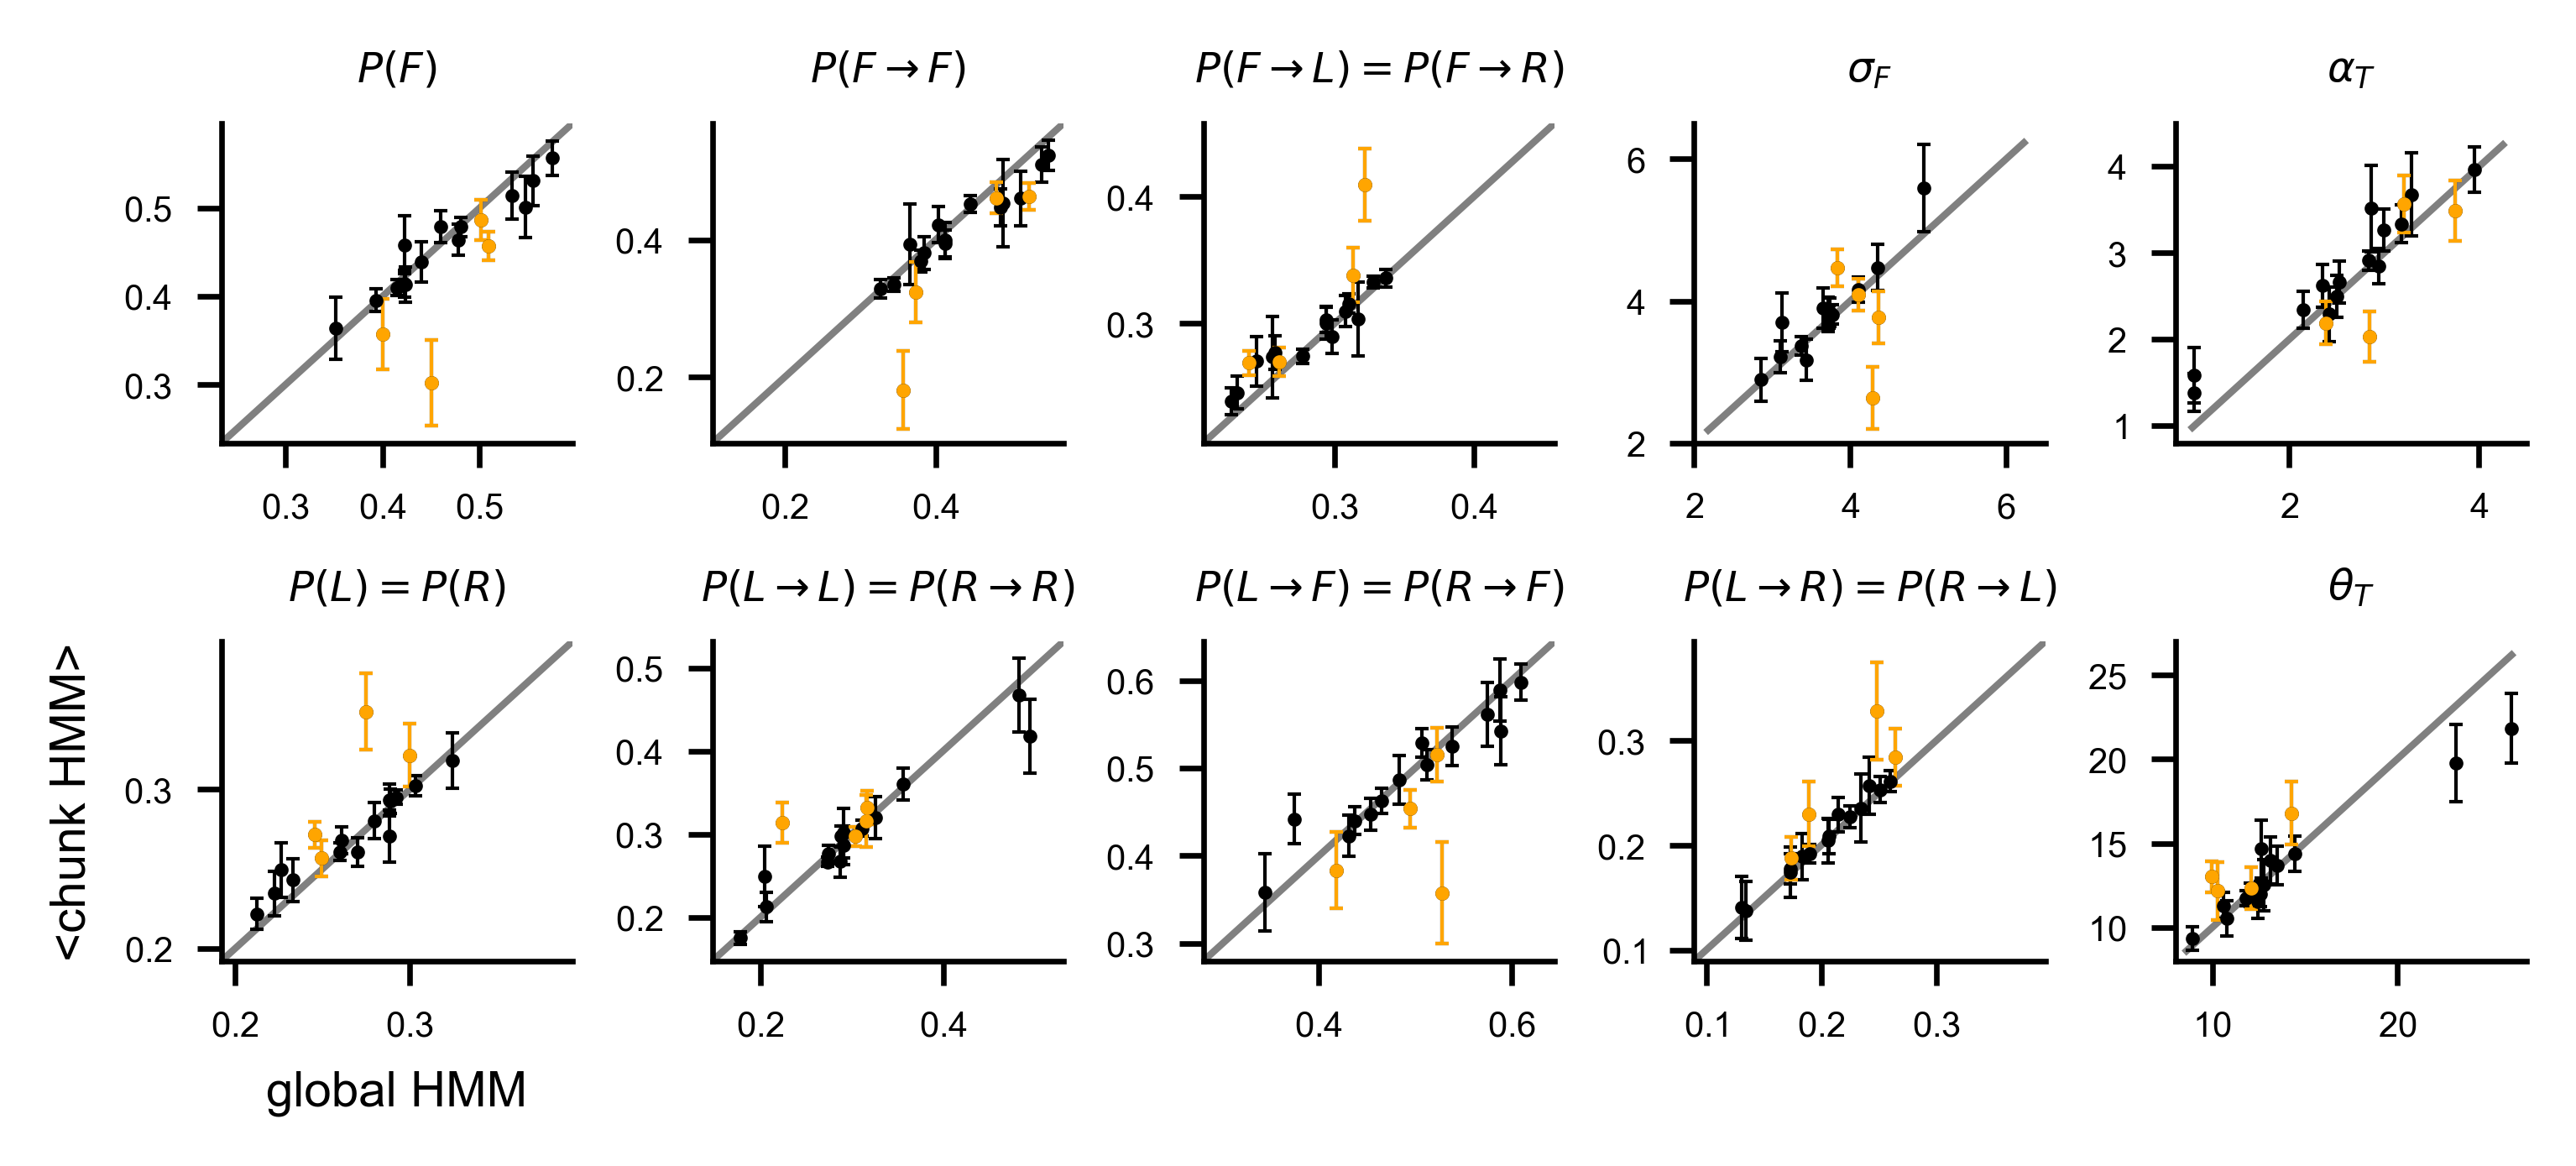

In [11]:
fig, axs = plt.subplots(figsize=(1*5,1.1*2), ncols=5, nrows=2, constrained_layout=True)

ax = axs[0,0]
ax.set_title(r"$P(F)$",fontdict={'fontsize':6})
id_ax(ax, Pglobs[:,0], Pchunks_m[:,0], Pchunks_s[:,0])

ax = axs[1,0]
ax.set_title(r"$P(L) = P(R)$",fontdict={'fontsize':6})
id_ax(ax, Pglobs[:,1], Pchunks_m[:,1], Pchunks_s[:,1])

ax = axs[0,1]
ax.set_title(r"$P(F \rightarrow F)$",fontdict={'fontsize':6})
id_ax(ax, Tglobs[:,0,0], Tchunks_m[:,0,0], Tchunks_s[:,0,0])

ax = axs[1,1]
ax.set_title(r"$P(L \rightarrow L) = P(R \rightarrow R)$",fontdict={'fontsize':6})
id_ax(ax, Tglobs[:,1,1], Tchunks_m[:,1,1], Tchunks_s[:,1,1])

ax = axs[0,2]
ax.set_title(r"$P(F \rightarrow L) = P(F \rightarrow R)$",fontdict={'fontsize':6})
id_ax(ax, Tglobs[:,0,1], Tchunks_m[:,0,1], Tchunks_s[:,0,1])

ax = axs[1,2]
ax.set_title(r"$P(L \rightarrow F) = P(R \rightarrow F)$",fontdict={'fontsize':6})
id_ax(ax, Tglobs[:,1,0], Tchunks_m[:,1,0], Tchunks_s[:,1,0])

ax = axs[0,3]
ax.set_title(r"$\sigma_F$",fontdict={'fontsize':6})
id_ax(ax, Eglobs[:,0], Echunks_m[:,0], Echunks_s[:,0])
ax.set_xlim(2,6.5)
ax.set_ylim(2,6.5)

ax = axs[1,3]
ax.set_title(r"$P(L \rightarrow R) = P(R \rightarrow L)$",fontdict={'fontsize':6})
id_ax(ax, Tglobs[:,1,2], Tchunks_m[:,1,2], Tchunks_s[:,1,2])

ax = axs[0,4]
ax.set_title(r"$\alpha_T$",fontdict={'fontsize':6})
id_ax(ax, Eglobs[:,1], Echunks_m[:,1], Echunks_s[:,1])
ax.set_xlim(0.8,4.5)
ax.set_ylim(0.8,4.5)

ax = axs[1,4]
ax.set_title(r"$\theta_T$",fontdict={'fontsize':6})
id_ax(ax, Eglobs[:,2], Echunks_m[:,2], Echunks_s[:,2])
ax.set_xlim(8,27)
ax.set_ylim(8,27)

ax = axs[1,0]
ax.set_xlabel("global HMM")
ax.set_ylabel("<chunk HMM>")

fig.savefig("panels/Fig5/supps/id_params_all.svg")